[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/activation/early_stopping.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Early stopping

This notebook shows how to use early stopping to avoid overfitting in a neural network. We will use the [Fashion-MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset and a multilayer perceptron (MLP) model.

<img src="img/fashion-mnist.png" width="600px"/>

In [8]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/deep-learning/activation'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/img/* img/.

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


## Data preparation

We download, split, and scale the Fashion-MNIST dataset. 

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# break the training set into training and validation sets
N_VAL_INSTANCES = 10_000
X_train, y_train = X_train_full[:-N_VAL_INSTANCES], y_train_full[:-N_VAL_INSTANCES]
X_val, y_val = X_train_full[-N_VAL_INSTANCES:], y_train_full[-N_VAL_INSTANCES:]
# show dataset info
print(f"Shape of X_train = {X_train.shape} and y_train = {y_train.shape}.")
print(f"Shape of X_val = {X_val.shape} and y_val = {y_val.shape}.")
print(f"Shape of X_test = {X_test.shape} and y_test = {y_test.shape}.")
CLASS_LABELS = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# We rescale the colors to real numbers between 0 and 1
X_train, X_val, X_test = X_train / 255, X_val / 255, X_test / 255

Shape of X_train = (50000, 28, 28) and y_train = (50000,).
Shape of X_val = (10000, 28, 28) and y_val = (10000,).
Shape of X_test = (10000, 28, 28) and y_test = (10000,).


## Multilayer Perceptron (MLP) model

We create a MLP network with two hidden layers of 300 and 100 neurons (ReLU activation function) and an output layer of 10 neurons (softmax activation function). 

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training with a fixed number of epochs

We first train the model with 20 epochs and batch size of 32.

Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.4919 - accuracy: 0.8235 - val_loss: 0.4268 - val_accuracy: 0.8421
Epoch 2/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3669 - accuracy: 0.8656 - val_loss: 0.3782 - val_accuracy: 0.8656
Epoch 3/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.3313 - accuracy: 0.8789 - val_loss: 0.3654 - val_accuracy: 0.8702
Epoch 4/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.3058 - accuracy: 0.8869 - val_loss: 0.3328 - val_accuracy: 0.8816
Epoch 5/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2871 - accuracy: 0.8923 - val_loss: 0.3304 - val_accuracy: 0.8792
Epoch 6/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.2701 - accuracy: 0.9006 - val_loss: 0.3177 - val_accuracy: 0.8861
Epoch 7/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2596 - accuracy: 0.9030 - val_loss: 0.3117 - val_accuracy:

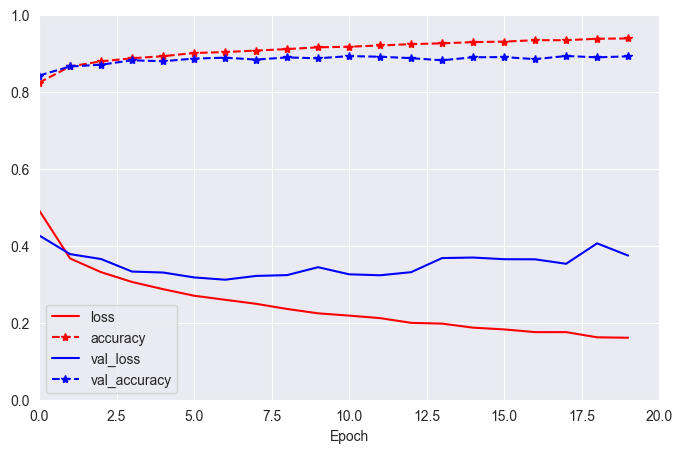

In [11]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
EPOCHS = 20
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_val, y_val))
# Let's take a look at how test and train loss and accuracy evolved during training
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, EPOCHS], ylim=[0, 1], grid=True, xlabel="Epoch",
    # red/blue, dashed(--), continuous (-), shape(. or *)
    style=["r-", "r--*", "b-", "b--*"])  # train-loss=red(-), train-accuracy=red(--*), val_loss=blue(-), val_accuracy=blue(--*)
plt.show()

## Early stopping

We now train the model with early stopping. To that aim, we create a callback function that stops when, after `patience` epochs, the val loss is not improving. That is why it is called early stop. We use the `EarlyStopping` callback from Keras.

Epoch 1/20
1563/1563 [==============================] - 9s 5ms/step - loss: 0.1571 - accuracy: 0.9396 - val_loss: 0.3834 - val_accuracy: 0.8916
Epoch 2/20
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1551 - accuracy: 0.9409 - val_loss: 0.3860 - val_accuracy: 0.8909
Epoch 3/20
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1481 - accuracy: 0.9440 - val_loss: 0.3908 - val_accuracy: 0.8920


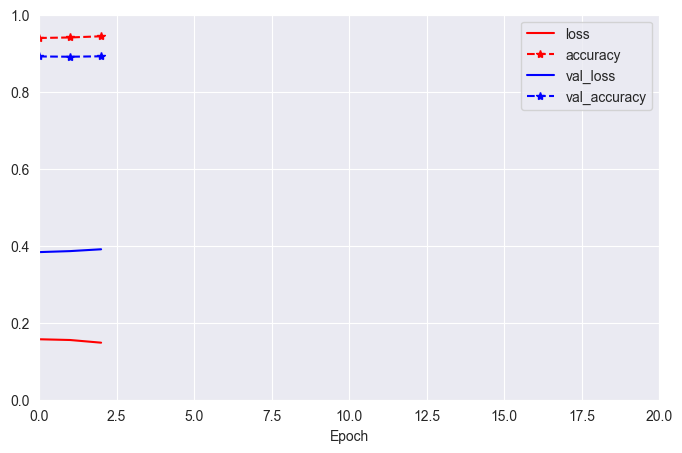

In [12]:
# Recompile the model to forget the learned weights
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# We create a callback for early stopping (patience=2)
# restore_best_weights = True makes the model to choose the one with the best weights (forget the last ones)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
# fit the model, passing the callback
history_early_stop = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_val, y_val),
                               callbacks=[early_stopping_callback])

# Let's take a look at how test and train loss and accuracy evolved during training
pd.DataFrame(history_early_stop.history).plot(
    figsize=(8, 5), xlim=[0, EPOCHS], ylim=[0, 1], grid=True, xlabel="Epoch",
    # red/blue, dashed(--), continuous (-), shape(. or *)
    style=["r-", "r--*", "b-", "b--*"])  # train-loss=red(-), train-accuracy=red(--*), val_loss=blue(-), val_accuracy=blue(--*)
plt.show()

## ✨ Questions ✨ 

1. What is the difference between the two previous training processes?
2. Identify the two main benefits of early stopping?

### Answers

*Write your answers here.*

